Autores: Bruno Leal Fonseca & Guilherme Namen Pimenta

# CHAT GPT 4.o Canvas

## Business Understanding

**Objetivo do Dataset**
O dataset MAFAULDA foi desenvolvido para monitorar e identificar falhas em sistemas de motores utilizando medições de vibração do rotor. Este conjunto de dados permite analisar o comportamento do motor sob diferentes condições de funcionamento, incluindo condições normais e cenários de falha. Ele pode ser usado para:

Diagnosticar falhas antes que causem paradas no sistema.
Desenvolver algoritmos de manutenção preditiva.
Melhorar a confiabilidade e a eficiência de motores industriais.
Seu uso é altamente relevante para a indústria, pois falhas inesperadas em motores podem levar a interrupções significativas na produção e a altos custos de manutenção

**Origem dos Dados**
O dataset foi desenvolvido pela equipe da Universidade Federal do Rio de Janeiro (UFRJ) e está disponível no portal do Grupo de Monitoramento e Diagnóstico de Sistemas Mecânicos (MDS). As medições foram realizadas em um motor com um rotor a 50 Hz e armazenadas em diferentes categorias com base nos tipos e severidades das falhas introduzidas.

**Características do Dataset**
- Estrutura do Dataset: O conjunto de dados está organizado em pastas que representam diferentes condições de falha, como desalinhamento horizontal e vertical, desequilíbrio, e condições normais. Subpastas indicam níveis de severidade específicos (exemplo: 0.5 mm de desalinhamento).

- Colunas de Dados: Cada arquivo CSV contém medições de vibração em várias partes do motor:

    - tachometer: Medição do tacômetro.
    - underhang_1, underhang_2, underhang_3: Vibrações em sensores posicionados no lado inferior.
    - overhang_1, overhang_2, overhang_3: Vibrações em sensores posicionados no lado superior.
    - microphone: Medição de som/vibração ao redor do motor.
- Linhas e Colunas:

    - Linhas: Representam instantes de tempo durante a coleta de dados.
    - Colunas: Sensores ou medições relacionadas às condições do motor.

**Relação com o Problema de Negócio**
Este dataset é relevante para o diagnóstico de falhas e a manutenção preditiva de sistemas industriais. A detecção de anomalias com base em medições de vibração pode:

1. Prevenir falhas catastróficas: Identificar tendências de falhas antes que elas ocorram.
2. Reduzir custos de manutenção: Implementar estratégias baseadas na condição real do motor, evitando manutenções desnecessárias.
3. Melhorar a eficiência operacional: Garantir o funcionamento contínuo e otimizado de sistemas industriais.

**Próximos Passos**
Com este entendimento inicial, podemos:

1. Processar os dados para gerar atributos descritivos que capturam o comportamento vibracional do motor.
2. Aplicar algoritmos de agrupamento, como DBSCAN, para identificar padrões e possíveis anomalias.
3. Validar a eficácia do agrupamento utilizando os rótulos originais (normal e falhas).

## Data Understanding & Data Preparation

Gostaria de aplicar um algoritmo de agrupamento na seguinte base de dados:
https://www02.smt.ufrj.br/~offshore/mfs/page_01.html
Nela foram feitas algumas medições de vibrações do rotor do motor a 50 Hz. A estrutura de pasta que foi montada segue o seguinte arquivo anexado. Gostaria de primeiramente carregar esses dados usando polars dataframes

-----------------

Para carregar esses dados usando Polars DataFrames, você pode criar uma função que percorra as pastas e leia os arquivos CSV correspondentes. Aqui está um exemplo de código em Python:

In [ ]:
import polars as pl
import os

# Função para carregar os dados
def load_vibration_data(base_path):
    data = []
    labels = []
    
    # Percorrer as pastas
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                # Ler o arquivo CSV
                df = pl.read_csv(file_path)
                # Adicionar os dados ao dataframe principal
                data.append(df)
                # Extrair o label com base no nome do diretório
                label = os.path.basename(os.path.dirname(file_path))
                labels.append(label)
    
    # Combinar os dados em um único dataframe
    combined_df = pl.concat(data)
    return combined_df, labels

# Caminho base para os dados
base_path = "Data"  # Substitua pelo caminho correto dos seus dados

# Carregar os dados
combined_df, labels = load_vibration_data(base_path)

# Exibir as primeiras linhas
print(combined_df.head())


Os dados consistem em séries temporais de vibrações dos motores. Há alguma forma de gerar atributos que consigam caracterizar bem os dados para aplicar um algoritmo de agrupamento capaz de detectar quando há uma anomalia?

------------------------

Sim, para caracterizar séries temporais de vibrações de motores e aplicar algoritmos de agrupamento para detectar anomalias, você pode gerar atributos derivados das séries temporais que capturem padrões relevantes para análise. Abaixo estão algumas categorias de atributos úteis, além de métodos para extraí-los:

1. Estatísticas Básicas
Média, mediana, variância e desvio padrão da amplitude.
Amplitude máxima e mínima.
Curtose e assimetria (skewness).
Energia da série temporal.
Exemplo em Polars:

````def basic_statistics(df):
    stats = df.select([
        pl.col("signal").mean().alias("mean"),
        pl.col("signal").std().alias("std_dev"),
        pl.col("signal").min().alias("min"),
        pl.col("signal").max().alias("max"),
        pl.col("signal").kurtosis().alias("kurtosis"),
        pl.col("signal").skew().alias("skewness")
    ])
    return stats
````

2. Atributos no Domínio da Frequência
Transformar os dados para o domínio da frequência pode revelar padrões ocultos associados a vibrações específicas:

Frequências dominantes: Componentes de maior magnitude no espectro.
Energia em bandas específicas: Soma da potência em faixas de frequência (e.g., baixas, médias, altas).
Transformada de Fourier (FFT): Frequência fundamental e harmônicas.
Exemplo com scipy:

````import numpy as np
from scipy.fftpack import fft

def frequency_features(signal, sampling_rate):
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/sampling_rate)
    fft_values = np.abs(fft(signal))
    
    # Seleção de características
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values**2)  # Energia total
    return {
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy
    }
````

3. Características Derivadas do Tempo
Capturam comportamentos ao longo do tempo:

Autocorrelação: Mede a relação do sinal consigo mesmo em diferentes atrasos (lags).
Entropia de Permutação: Avalia a complexidade do sinal.
Taxa de cruzamento de zero: Frequência com que o sinal cruza o zero (relacionado à oscilação).
Exemplo de cruzamento de zero:

````def zero_crossing_rate(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings) / len(signal)
````

4. Características no Domínio do Tempo-Frequência
Transformada Wavelet: Identifica padrões transitórios.
Espectrograma: Representação de frequência ao longo do tempo. Essas técnicas são úteis para sinais com características que mudam no tempo.

5. Técnicas Avançadas
Redução de Dimensionalidade: Usar PCA (Principal Component Analysis) para reduzir a dimensionalidade das características derivadas.
Aprendizado de Representação:
Redes Neurais (e.g., autoencoders).
Extração de embeddings usando técnicas de aprendizado profundo.

Pipeline para Detectar Anomalias

Pré-processamento: Normalizar os dados e lidar com ruído.

Geração de Atributos: Usar as categorias acima para transformar os dados.

Agrupamento: Aplicar algoritmos como K-Means, DBSCAN ou Isolation Forest nos atributos derivados.

Validação: Avaliar os resultados manualmente ou com labels de anomalias, caso existam.

Se quiser, posso implementar parte desse pipeline em Python para os seus dados, como a extração de atributos estatísticos ou baseados em frequência.

Sim por favor, faça a implementação completa

--------------------------

Aqui está a implementação completa de um pipeline para caracterizar séries temporais de vibrações e aplicar algoritmos de agrupamento para detectar anomalias:

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


# Step 1: Load Data
def load_vibration_data(base_path):
    data = []
    labels = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                df = pl.read_csv(file_path)
                data.append(df)
                label = os.path.basename(os.path.dirname(file_path))
                labels.append(label)

    return data, labels


# Step 2: Extract Features
def extract_features(df, sampling_rate):
    signal = df["signal"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values**2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }


# Step 3: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in data:
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)


# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "motorvibration/Data"  # Update with the correct path

    # Sampling rate (assumed, update as needed)
    sampling_rate = 50

    # Load Data
    data, labels = load_vibration_data(base_path)
    print(data)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)


Cada arquivo csv apresenta 8 colunas, elas apontam as medições na imagem. Portanto as colunas serão:
dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
Poderia também colocar uma barra de carregamento para indicar que a base está sendo carregada? 

--------------

Adicionei uma barra de carregamento usando a biblioteca tqdm para indicar o progresso do carregamento dos arquivos e da extração de características. Além disso, atualizei as colunas do dataset para refletir os nomes fornecidos. Certifique-se de que a biblioteca tqdm esteja instalada (pip install tqdm) antes de executar o código. Se precisar de ajustes adicionais, é só avisar!

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from tqdm import tqdm

# Step 1: Load Data
def load_vibration_data(base_path):
    dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
    data = []
    labels = []

    for root, dirs, files in os.walk(base_path):
        for file in tqdm(files, desc="Loading files"):
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                df = pl.read_csv(file_path, has_header=True, new_columns=dataset_columns_name)
                data.append(df)
                label = os.path.basename(os.path.dirname(file_path))
                labels.append(label)

    return data, labels

# Step 2: Extract Features
def extract_features(df, sampling_rate):
    signal = df["microphone"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values ** 2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }

# Step 3: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in tqdm(data, desc="Extracting features"):
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)


# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "Data"  # Update with the correct path

    # Sampling rate (update as needed)
    sampling_rate = 50000

    # Load Data
    data, labels = load_vibration_data(base_path)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)


Implementei a seguinte função para facilitar a listagem dos diversos arquivos que existem:


````def list_files(self) -> list:
    csv_files_list = []

    folders_list = os.listdir(self.dataset_path)
    for folder in folders_list:
        folder_path = os.path.join(self.dataset_path, folder)
        if os.path.isdir(folder_path):
            sub_folders_list = os.listdir(folder_path)
            for sub_folder in sub_folders_list:
                sub_folder_path = os.path.join(folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    list_csv = glob(f"{sub_folder_path}/*.csv")
                    for csv_file in list_csv:
                        csv_files_list.append((csv_file, csv_file))
                elif sub_folder_path.endswith(".csv"):
                    csv_files_list.append((sub_folder_path, sub_folder_path))

    return csv_files_list
````

--------

Adicionei a função list_files que você forneceu ao código existente e integrei sua utilização no pipeline principal para listar os arquivos antes de carregar os dados. Também inclui a exibição dos arquivos encontrados para facilitar a visualização. Se precisar de mais ajustes ou aprimoramentos, é só avisar!

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from tqdm import tqdm
from glob import glob

# Step 1: List Files
def list_files(dataset_path):
    csv_files_list = []

    folders_list = os.listdir(dataset_path)
    for folder in folders_list:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            sub_folders_list = os.listdir(folder_path)
            for sub_folder in sub_folders_list:
                sub_folder_path = os.path.join(folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    list_csv = glob(f"{sub_folder_path}/*.csv")
                    for csv_file in list_csv:
                        csv_files_list.append((csv_file, csv_file))
                elif sub_folder_path.endswith(".csv"):
                    csv_files_list.append((sub_folder_path, sub_folder_path))

    return csv_files_list

# Step 2: Load Data
def load_vibration_data(base_path):
    dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
    data = []
    labels = []

    for root, dirs, files in os.walk(base_path):
        for file in tqdm(files, desc="Loading files"):
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                df = pl.read_csv(file_path, has_header=True, new_columns=dataset_columns_name)
                data.append(df)
                label = os.path.basename(os.path.dirname(file_path))
                labels.append(label)

    return data, labels

# Step 3: Extract Features
def extract_features(df, sampling_rate):
    signal = df["microphone"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values ** 2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }

# Step 4: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in tqdm(data, desc="Extracting features"):
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)


# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "Data"  # Update with the correct path

    # Sampling rate (update as needed)
    sampling_rate = 50000

    # List Files
    file_list = list_files(base_path)
    print("Files found:", file_list)

    # Load Data
    data, labels = load_vibration_data(base_path)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)

    # Clustering
    reduced_features, clusters = cluster_data(features)

    # Visualize Results
    visualize_clusters(reduced_features, clusters)

    # Display cluster assignment
    print("Cluster Assignments:", clusters)


## Modeling

Poderia fazer a implementação de um algoritmo de agrupamento adequado para essa tarefa de detecção de anomalias nos dados

------

Aqui está uma implementação do algoritmo DBSCAN. Esse algoritmo consegue ser muito eficiente para agrupar regiões baseado na densidade, os regimes de operação normal devem ser distinguir dos demais no espaço de atributos, ficando agrupados em uma região de similaridade entre eles.

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from tqdm import tqdm
from glob import glob

# Step 1: List Files
def list_files(dataset_path):
    csv_files_list = []

    folders_list = os.listdir(dataset_path)
    for folder in folders_list:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            sub_folders_list = os.listdir(folder_path)
            for sub_folder in sub_folders_list:
                sub_folder_path = os.path.join(folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    list_csv = glob(f"{sub_folder_path}/*.csv")
                    for csv_file in list_csv:
                        csv_files_list.append((csv_file, csv_file))
                elif sub_folder_path.endswith(".csv"):
                    csv_files_list.append((sub_folder_path, sub_folder_path))

    return csv_files_list

# Step 2: Load Data
def load_vibration_data_from_list(file_list):
    dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
    data = []
    labels = []

    for file_path, label in tqdm(file_list, desc="Loading files"):
        df = pl.read_csv(file_path, has_header=True, new_columns=dataset_columns_name)
        data.append(df)
        labels.append(label)

    return data, labels

# Step 3: Extract Features
def extract_features(df, sampling_rate):
    signal = df["microphone"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values ** 2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }

# Step 4: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in tqdm(data, desc="Extracting features"):
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)

# Step 5: Preprocessing and Clustering
def cluster_data(features):
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Dimensionality Reduction (optional)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(scaled_features)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(reduced_features)

    return reduced_features, clusters

# Step 6: Visualize Clusters
def visualize_clusters(reduced_features, clusters):
    import matplotlib.pyplot as plt

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis")
    plt.colorbar(label="Cluster Label")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("DBSCAN Clustering Results")
    plt.show()


# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "Data"  # Update with the correct path

    # Sampling rate (update as needed)
    sampling_rate = 50000

    # List Files
    file_list = list_files(base_path)
    print("Files found:", file_list)

    # Load Data
    data, labels = load_vibration_data_from_list(file_list)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)

    # Clustering
    reduced_features, clusters = cluster_data(features)

    # Visualize Results
    visualize_clusters(reduced_features, clusters)


Poderia gerar um segundo plot no final, onde são apontados os rótulos, nas listas retornadas pelo list_files há tuplas elas indicam:
(caminho_do_arquivo, nome_do_arquivo). Todo arquivo que tenha a palavra "normal"  é uma medição normal, caso contrário, é uma medição onde há anomalia

--------

Adicionei um segundo gráfico que classifica os arquivos como "normal" ou "anomaly" com base no nome do arquivo e os exibe usando diferentes cores. Certifique-se de que o conjunto de dados contém os nomes esperados para que os rótulos sejam atribuídos corretamente. Se precisar de mais ajustes, é só avisar!

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from tqdm import tqdm
from glob import glob

# Step 1: List Files
def list_files(dataset_path):
    csv_files_list = []

    folders_list = os.listdir(dataset_path)
    for folder in folders_list:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            sub_folders_list = os.listdir(folder_path)
            for sub_folder in sub_folders_list:
                sub_folder_path = os.path.join(folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    list_csv = glob(f"{sub_folder_path}/*.csv")
                    for csv_file in list_csv:
                        csv_files_list.append((csv_file, csv_file))
                elif sub_folder_path.endswith(".csv"):
                    csv_files_list.append((sub_folder_path, sub_folder_path))

    return csv_files_list

# Step 2: Load Data
def load_vibration_data_from_list(file_list):
    dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
    data = []
    labels = []

    for file_path, label in tqdm(file_list, desc="Loading files"):
        df = pl.read_csv(file_path, has_header=True, new_columns=dataset_columns_name)
        data.append(df)
        labels.append(label)

    return data, labels

# Step 3: Extract Features
def extract_features(df, sampling_rate):
    signal = df["microphone"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values ** 2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }

# Step 4: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in tqdm(data, desc="Extracting features"):
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)

# Step 5: Preprocessing and Clustering
def cluster_data(features):
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Dimensionality Reduction (optional)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(scaled_features)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(reduced_features)

    return reduced_features, clusters

# Step 6: Visualize Clusters
def visualize_clusters(reduced_features, clusters):
    import matplotlib.pyplot as plt

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis")
    plt.colorbar(label="Cluster Label")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("DBSCAN Clustering Results")
    plt.show()

def visualize_labels(file_list, clusters):
    import matplotlib.pyplot as plt

    labels = ["normal" if "normal" in name.lower() else "anomaly" for _, name in file_list]
    color_map = {"normal": "blue", "anomaly": "red"}
    colors = [color_map[label] for label in labels]

    plt.scatter(clusters[:, 0], clusters[:, 1], c=colors, label=labels, alpha=0.6)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Visualization by Labels (Normal vs Anomaly)")
    plt.show()

# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "Data"  # Update with the correct path

    # Sampling rate (update as needed)
    sampling_rate = 50000

    # List Files
    file_list = list_files(base_path)
    print("Files found:", file_list)

    # Load Data
    data, labels = load_vibration_data_from_list(file_list)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)

    # Clustering
    reduced_features, clusters = cluster_data(features)

    # Visualize Results
    visualize_clusters(reduced_features, clusters)

    # Second Plot: Visualization by Labels
    visualize_labels(file_list, reduced_features)

    # Display cluster assignment
    print("Cluster Assignments:", clusters)


## Evaluation

Poderia gerar métricas de qualidade, baseadas nos rótulos originais para dizer o quão bom o agrupamento foi em discernir o regime de funcionamento normal dos demais? 

---------

Adicionei uma função para avaliar a qualidade do agrupamento com base nos rótulos originais. A função evaluate_clustering gera a matriz de confusão e o relatório de classificação, fornecendo métricas como precisão, recall e F1-score para diferenciar medições normais e anômalas. Certifique-se de executar o código atualizado para analisar os resultados do agrupamento. Se precisar de mais ajustes, é só avisar!

In [ ]:
import os
import polars as pl
import numpy as np
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from glob import glob

# Step 1: List Files
def list_files(dataset_path):
    csv_files_list = []

    folders_list = os.listdir(dataset_path)
    for folder in folders_list:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            sub_folders_list = os.listdir(folder_path)
            for sub_folder in sub_folders_list:
                sub_folder_path = os.path.join(folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    list_csv = glob(f"{sub_folder_path}/*.csv")
                    for csv_file in list_csv:
                        csv_files_list.append((csv_file, csv_file))
                elif sub_folder_path.endswith(".csv"):
                    csv_files_list.append((sub_folder_path, sub_folder_path))

    return csv_files_list

# Step 2: Load Data
def load_vibration_data_from_list(file_list):
    dataset_columns_name = ["tachometer", "underhang_1", "underhang_2", "underhang_3", "overhang_1", "overhang_2", "overhang_3", "microphone"]
    data = []
    labels = []

    for file_path, label in tqdm(file_list, desc="Loading files"):
        df = pl.read_csv(file_path, has_header=True, new_columns=dataset_columns_name)
        data.append(df)
        labels.append(label)

    return data, labels

# Step 3: Extract Features
def extract_features(df, sampling_rate):
    signal = df["microphone"].to_numpy()

    # Basic Statistics
    mean = np.mean(signal)
    std_dev = np.std(signal)
    min_val = np.min(signal)
    max_val = np.max(signal)
    kurtosis = pl.Series(signal).kurtosis()
    skewness = pl.Series(signal).skew()

    # Frequency Domain Features
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)
    fft_values = np.abs(fft(signal))
    dominant_freq = freq[np.argmax(fft_values)]
    energy = np.sum(fft_values ** 2)

    # Time Domain Features
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)

    return {
        "mean": mean,
        "std_dev": std_dev,
        "min": min_val,
        "max": max_val,
        "kurtosis": kurtosis,
        "skewness": skewness,
        "dominant_frequency": dominant_freq,
        "frequency_energy": energy,
        "zero_crossing_rate": zero_crossing_rate,
    }

# Step 4: Build Feature Matrix
def build_feature_matrix(data, sampling_rate):
    features = []
    for df in tqdm(data, desc="Extracting features"):
        features.append(extract_features(df, sampling_rate))

    return pl.DataFrame(features)

# Step 5: Preprocessing and Clustering
def cluster_data(features):
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Dimensionality Reduction (optional)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(scaled_features)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(reduced_features)

    return reduced_features, clusters

# Step 6: Visualize Clusters
def visualize_clusters(reduced_features, clusters):
    import matplotlib.pyplot as plt

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis")
    plt.colorbar(label="Cluster Label")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("DBSCAN Clustering Results")
    plt.show()

def visualize_labels(file_list, clusters):
    import matplotlib.pyplot as plt

    labels = ["normal" if "normal" in name.lower() else "anomaly" for _, name in file_list]
    color_map = {"normal": "blue", "anomaly": "red"}
    colors = [color_map[label] for label in labels]

    plt.scatter(clusters[:, 0], clusters[:, 1], c=colors, label=labels, alpha=0.6)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Visualization by Labels (Normal vs Anomaly)")
    plt.show()

# Step 7: Evaluate Clustering Performance
def evaluate_clustering(file_list, clusters):
    true_labels = [0 if "normal" in name.lower() else 1 for _, name in file_list]
    predicted_labels = [0 if cluster == -1 else 1 for cluster in clusters]  # -1 (noise) as anomaly

    # Compute confusion matrix and classification report
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=["Normal", "Anomaly"])

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Main Pipeline
if __name__ == "__main__":
    # Base path to data
    base_path = "Data"  # Update with the correct path

    # Sampling rate (update as needed)
    sampling_rate = 50000

    # List Files
    file_list = list_files(base_path)
    print("Files found:", file_list)

    # Load Data
    data, labels = load_vibration_data_from_list(file_list)

    # Build Feature Matrix
    features = build_feature_matrix(data, sampling_rate)

    # Clustering
    reduced_features, clusters = cluster_data(features)

    # Visualize Results
    visualize_clusters(reduced_features, clusters)

    # Second Plot: Visualization by Labels
    visualize_labels(file_list, reduced_features)

    # Evaluate Clustering Performance
    evaluate_clustering(file_list, clusters)

    # Display cluster assignment
    print("Cluster Assignments:", clusters)


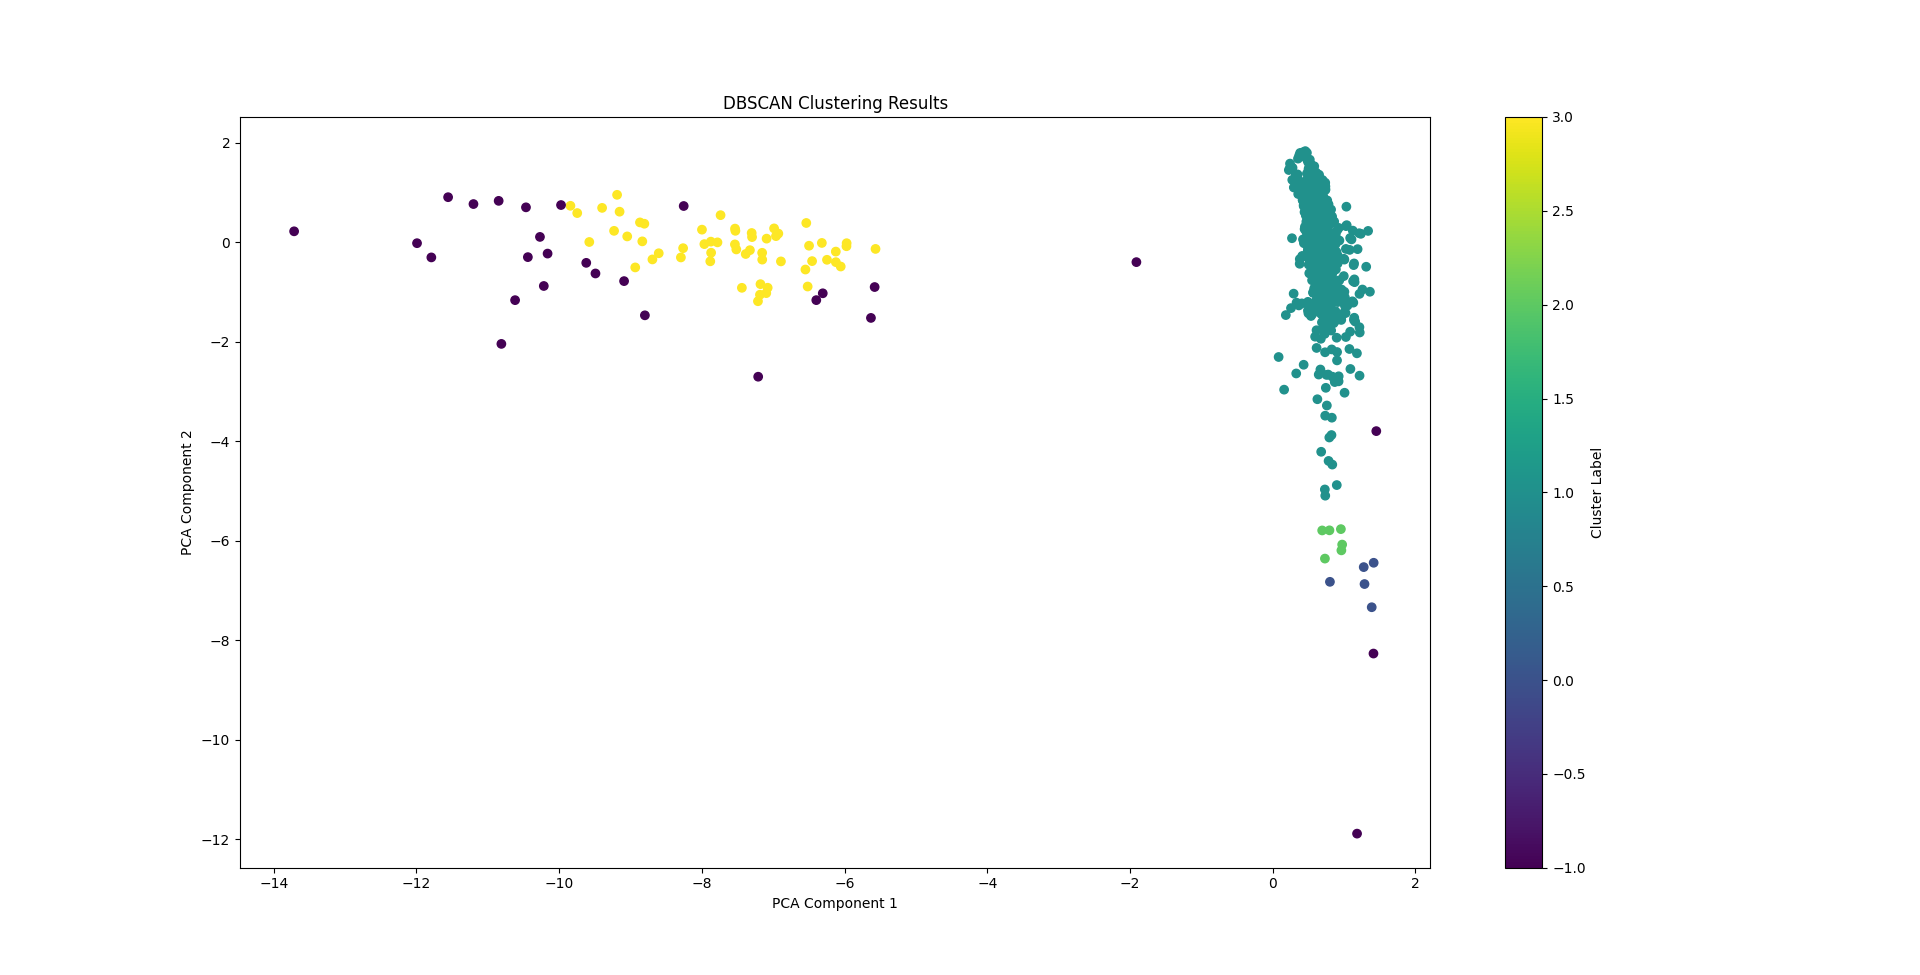

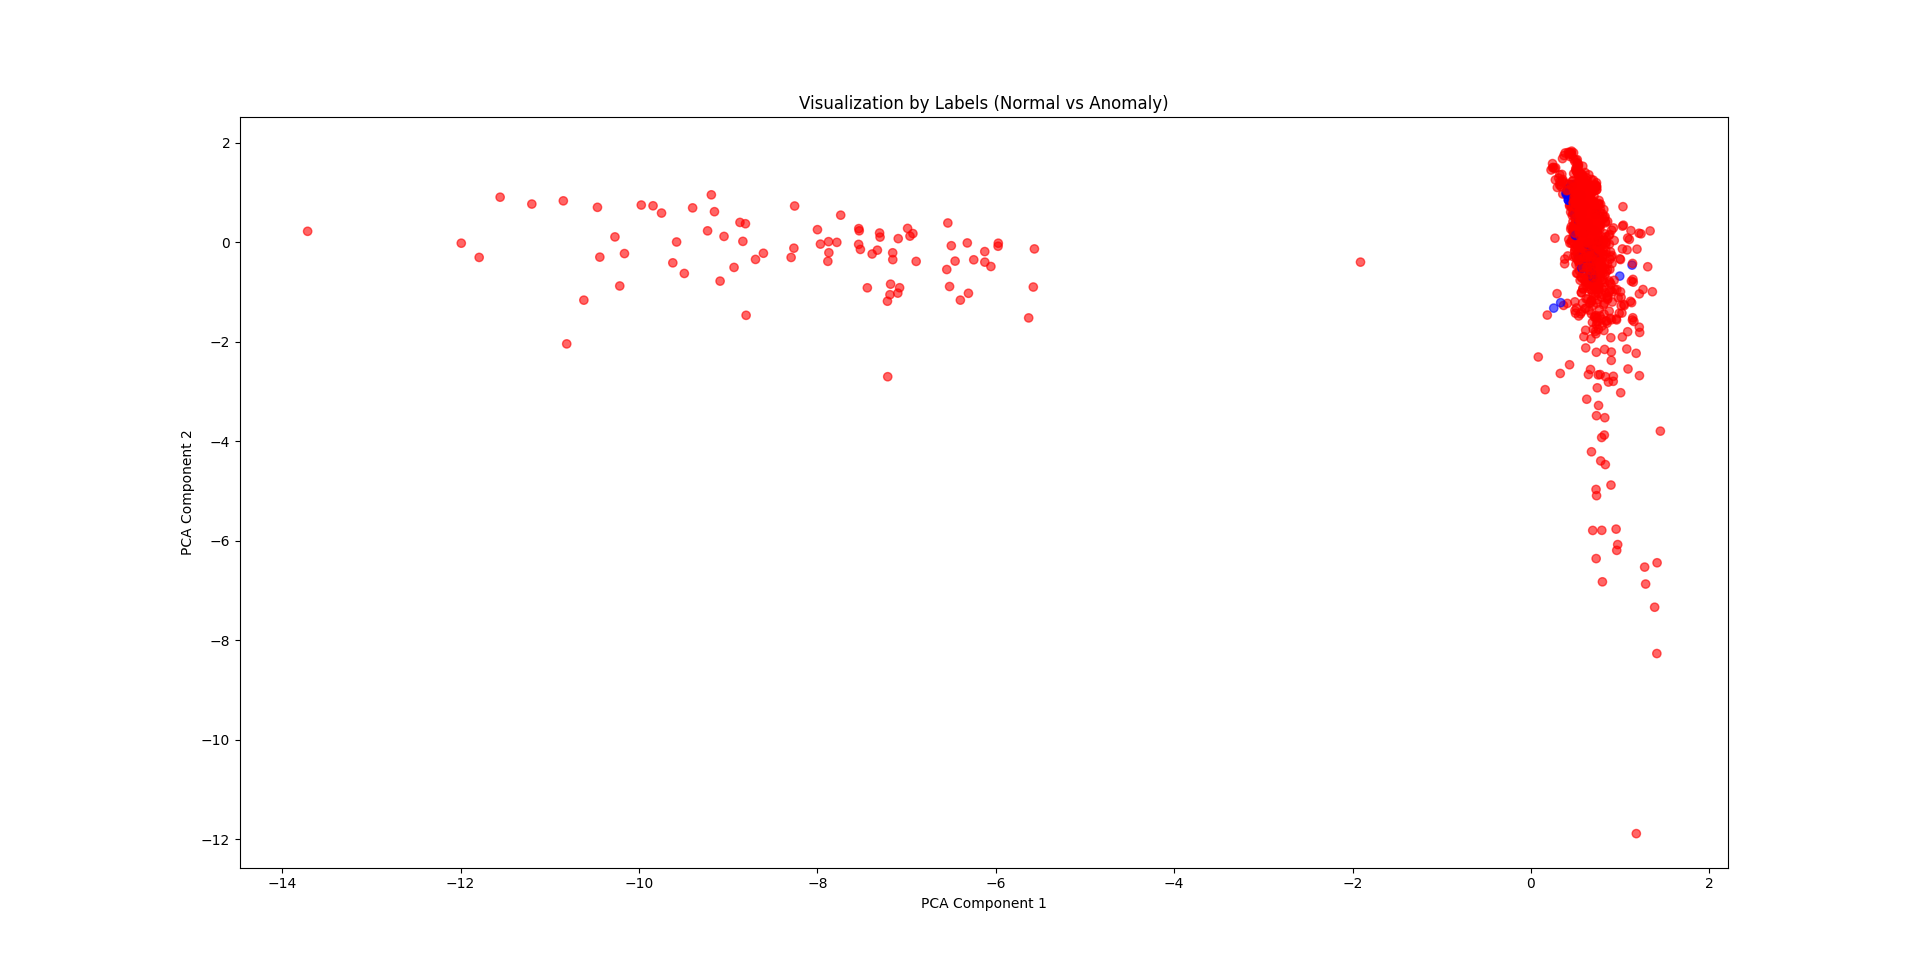

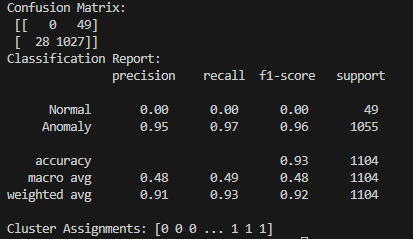

## Observações

O Chat GPT 4.o Canvas conseguiu gerar um código do inicio ao fim que fizesse o carregamento da base de dados; extração de atributos; ajuste de um algoritmo de agrupamento; vidualzão e avalição dos resultados.

Foram necessárias poucas intervenções e correções no código, a maioria no carregamento da base de dados. O modelo de LLM logrou sucesso em fazer um código funcional, mas não prático. Toda execução é necessário carregar a base de dados novamente, gerar os atributos e rodar o DBSCAN.

Avaliando os resultados, o projeto proposto pela LLM atingiu resultados longe do desejado. No segundo gráfico, é impossível achar uma região no espaço de atributos onde o regime de funcionamento normal do motor é diferente dos anômalos. Isso pode se dar por dois motivos principais:
1. A medição usada pode não ter sido a ideal: O "microphone" pode ser uma medição que é difícil de distinguir o funcionamento normal do motor dos demais. Logo, usar ela e únicamente ela como base para engenharia de atributos pode ter sido uma escolha com teor de informação pobre. 

Nem todo motor defeituoso indica claros problemas pelos ruídos, mas isso ocorre em casos mais graves, contudo, não foi possível nem constatar esse fatos nos resultados

2. Engenharia de atributos fraca: O novo espaço de atributos pode não ter expressado bem as características do sinal temporal. Usar apenas o harmônico mais significativo é um pouco ineficiente, pois, geralmente, em casos de medição de vibração, este vai estar nas mais baixas frequências, onde não há muita distinção entre sinais normais e anômalos; filtrar a faixa de frequência pode ser muito útil, além de selecionar outros harmônicos e seus módulos.

O PCA pode também ter feito com que a redução de dimensionalidade, para apenas os 2 primeiros componentes principais, tenha removido preciosas informações sobre os sinais.

Concluindo, o modelo de LLM avaliado consegue ser bem útil para criação de códigos funcionais, contudo, a falta de know-how sobre o desafio faz com que fique a solução final fique com uma performance bem abaixo do desejado.